In [1]:
pip install tensorflow

In [2]:
import tensorflow as tf
tf.__version__
tf.keras.__version__

'3.10.0'

Building keras with sequential API

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(64, input_dim=100, activation='relu'))
model.add(Dense(10, activation = 'softmax'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Building keras with Functional API

In [6]:
from keras.layers import Input, Dense, concatenate
from keras.models import Model
input1 = Input(shape=(100,))
input2 = Input(shape=(50,))
hidden1 = Dense(64, activation = 'relu')(input1)
hidden2 = Dense(32, activation = 'relu')(input2)
merged = concatenate([hidden1, hidden2])
output = Dense(10, activation = 'softmax')(merged)
model = Model(inputs = [input1, input2], outputs = output)

Today's project Deep Learning Hate Speech Detection

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import nltk
import string
import warnings
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('stopwords')
nltk.download('wordnet')
warnings.filterwarnings('ignore')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

Loading dataset
0 - hate speech
1 - offensive language
2 - neither

In [3]:
from google.colab import files
up = files.upload()

Saving Dataset---Hate-Speech-Detection-using-Deep-Learning.csv to Dataset---Hate-Speech-Detection-using-Deep-Learning.csv


In [4]:
df = pd.read_csv('Dataset---Hate-Speech-Detection-using-Deep-Learning.csv')

In [7]:
df.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [5]:
df.shape

(24783, 2)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   24783 non-null  int64 
 1   tweet   24783 non-null  object
dtypes: int64(1), object(1)
memory usage: 387.4+ KB


In [7]:
df.isnull().sum()

,0
class,0
tweet,0


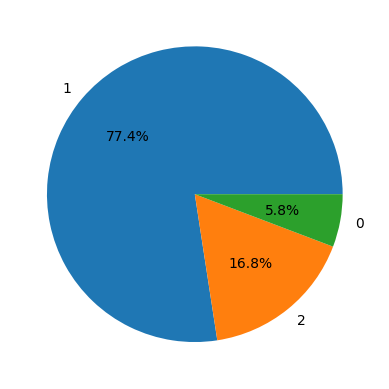

In [8]:
plt.pie(df['class'].value_counts().values, labels = df['class'].value_counts().index, autopct = '%1.1f%%')
plt.show()

Balancing the dataset

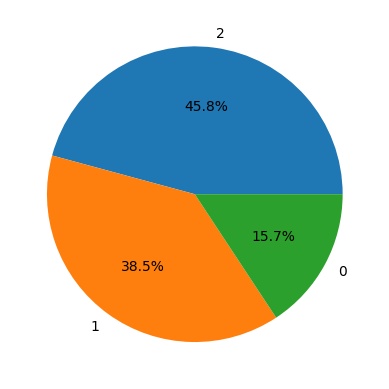

In [9]:
class_0 = df[df['class'] == 0] #hate speech
class_1 = df[df['class'] == 1].sample(n = 3500, random_state=42) #offensive language
class_2 = df[df['class'] == 2] #neutral

df_balanced = pd.concat([class_0, class_0, class_1, class_1, class_2, class_2], axis=0)   # upsampling + downsampling

plt.pie(df_balanced['class'].value_counts().values, labels = df_balanced['class'].value_counts().index, autopct='%1.1f%%')
plt.show()

Text Preprocessing
Textual data is highly unstructured and need attention on many aspects like:

Stopwords Removal
Punctuations Removal
Stemming or Lemmatization
Although removing data means loss of information but we need to do this to make the data perfect to feed into a machine learning model.

In [10]:
df['tweet'] = df['tweet'].str.lower()

punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)

df['tweet']= df['tweet'].apply(lambda x: remove_punctuations(x))
df.head()

,class,tweet
0,2,rt mayasolovely as a woman you shouldnt compl...
1,1,rt mleew17 boy dats coldtyga dwn bad for cuff...
2,1,rt urkindofbrand dawg rt 80sbaby4life you eve...
3,1,rt cganderson vivabased she look like a tranny
4,1,rt shenikaroberts the shit you hear about me ...


In [11]:
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return " ".join(words)

df_balanced['tweet'] = df_balanced['tweet'].apply(preprocess_text)

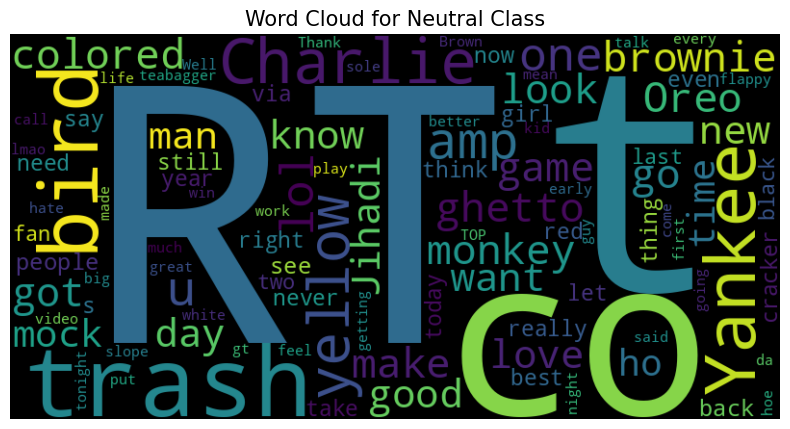

In [12]:
def plot_word_cloud(data, typ):
    corpus = " ".join(data['tweet'])
    wc = WordCloud(max_words=100, width=800, height=400, collocations=False).generate(corpus)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {typ} Class", fontsize=15)
    plt.show()

plot_word_cloud(df_balanced[df_balanced['class'] == 2], typ="Neutral")

Tokenization & Padding  
text data -> numerical sequences n pad them to fixed length

In [13]:
features = df_balanced['tweet']
target = df_balanced['class']
X_train, X_val, Y_train, Y_val = train_test_split(features, target, test_size=0.2, random_state=42)

# One-hot encode the labels
Y_train = pd.get_dummies(Y_train)
Y_val = pd.get_dummies(Y_val)

# Tokenization
max_words = 5000
max_len = 100
tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# Pad sequences
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_val_padded = pad_sequences(X_val_seq, maxlen=max_len, padding='post', truncating='post')

Build the model  We will implement a Sequential model like LSTM which will contain the following parts:

Embedding Layers to learn a featured vector representations of the input vectors.
Bidirectional LSTM layer to identify useful patterns in the sequence.
We have included BatchNormalization layers to enable stable and fast training and a Dropout layer before the final layer to avoid any possibility of overfitting.
The final layer is the output layer which outputs soft probabilities for the three classes.

While compiling a model we provide these three essential parameters:

optimizer - This is the method that helps to optimize the cost function by using gradient descent.
loss - The loss function by which we monitor whether the model is improving with training or not.
metrics - This helps to evaluate the model by predicting the training and the validation data.

In [14]:
from tensorflow import keras
from tensorflow.keras import layers

max_words = 10000
max_len = 100

model = keras.models.Sequential([
    layers.Embedding(input_dim=max_words, output_dim=32, input_length=max_len),
    layers.Bidirectional(layers.LSTM(16)),
    layers.Dense(512, activation='relu', kernel_regularizer='l1'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')
])

model.build(input_shape=(None, max_len))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 32)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 32)             │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 346,755 (1.32 MB)

 Trainable params: 345,731 (1.32 MB)

 Non-trainable params: 1,024 (4.00 KB)

Train the model using callbacks like EarlyStopping and ReduceLROnPlateau.

In [15]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
es = EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True)
lr = ReduceLROnPlateau(patience=2, monitor='val_loss', factor=0.5, verbose=0)

In [16]:
history = model.fit(X_train_padded, Y_train, epochs=50, batch_size=32, validation_data=(X_val_padded, Y_val), callbacks=[es, lr])

Epoch 1/50
455/455 ━━━━━━━━━━━━━━━━━━━━ 39s 71ms/step - accuracy: 0.7335 - loss: 2.9768 - val_accuracy: 0.8551 - val_loss: 0.6381 - learning_rate: 0.0010
Epoch 2/50
455/455 ━━━━━━━━━━━━━━━━━━━━ 42s 73ms/step - accuracy: 0.9035 - loss: 0.3433 - val_accuracy: 0.9068 - val_loss: 0.3373 - learning_rate: 0.0010
Epoch 3/50
455/455 ━━━━━━━━━━━━━━━━━━━━ 33s 72ms/step - accuracy: 0.9437 - loss: 0.2339 - val_accuracy: 0.8703 - val_loss: 0.4076 - learning_rate: 0.0010
Epoch 4/50
455/455 ━━━━━━━━━━━━━━━━━━━━ 40s 69ms/step - accuracy: 0.9618 - loss: 0.1782 - val_accuracy: 0.9327 - val_loss: 0.2928 - learning_rate: 0.0010
Epoch 5/50
455/455 ━━━━━━━━━━━━━━━━━━━━ 42s 71ms/step - accuracy: 0.9680 - loss: 0.1566 - val_accuracy: 0.9401 - val_loss: 0.2857 - learning_rate: 0.0010
Epoch 6/50
455/455 ━━━━━━━━━━━━━━━━━━━━ 31s 69ms/step - accuracy: 0.9750 - loss: 0.1248 - val_accuracy: 0.9511 - val_loss: 0.2600 - learning_rate: 0.0010
Epoch 7/50
455/455 ━━━━━━━━━━━━━━━━━━━━ 33s 72ms/step - accuracy: 0.9815 - l

Evaluate the model

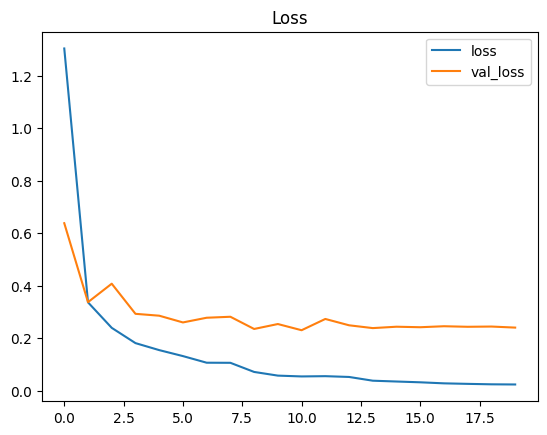

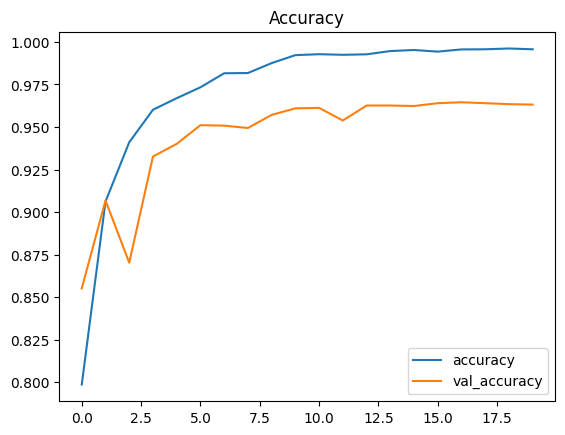

In [17]:
hist_df = pd.DataFrame(history.history)
hist_df[['loss', 'val_loss']].plot(title='Loss')
hist_df[['accuracy', 'val_accuracy']].plot(title='Accuracy')
plt.show()

Test Accuracy

In [18]:
test_loss, test_acc = model.evaluate(X_val_padded, Y_val)
print(f"Test accuracy: {test_acc: .2f}")

114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9660 - loss: 0.2388
Test accuracy:  0.96


Test with generate predictions on new text

In [25]:
def predict_text(text):
  seq = tokenizer.texts_to_sequences([text])
  padded = pad_sequences(seq, maxlen = max_len, padding='post', truncating='post')
  pred = model.predict(padded)[0]
  class_idx = np.argmax(pred)
  labels = {
      0: "Hate Speech",
      1: "Offensive Language",
      2: "Neither"
  }
  return labels[class_idx], pred

print(predict_text("I hate you so much"))
print(predict_text("Have a nice day"))
  #}
 # return "Hate Speech" if pred > 0.5 else "Non Hate Speech"

#print(predict_text("I hate you so much"))
#print(predict_text("Have a nice day"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
('Offensive Language', array([0.01949505, 0.97407645, 0.00642849], dtype=float32))
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
('Neither', array([3.1275470e-03, 5.4193373e-05, 9.9681818e-01], dtype=float32))
